<a href="https://colab.research.google.com/github/arminnorouzi/machine_learning_course_UofA_MECE610/blob/main/L07_Generative_AI/L07a_Generative_adversarial_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L07a- Generative Adversarial Network (GAN)


   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory


**Table of Contents:**
1.  Intorduction to Generative Adversarial Network (GAN)
2.  Tensorflow implementation of GAN


# 1. Intorduction to Generative Adversarial Network (GAN)
A type of deep learning model called a Generative Adversarial Network (GAN) involves two neural networks competing against each other in a zero-sum game framework. GANs aim to generate synthetic data that looks like a known data distribution. Gans consist of two main componenet or model (neural networks), **Generator** and **Discriminator**, which compete against each other in a game-like scenario. The GAN is trained on both real data and synthetic data generated by the Generator. The Discriminator's role is to differentiate between real and fake data, while the Generator's job is to learn from its mistakes and produce more realistic synthetic data. Initially, the Generator is likely to generate low-quality, noisy data that does not reflect the real data distribution, but it improves over time as it learns from the Discriminator's feedback. Main structure in shown schematically here:

![picture](https://github.com/arminnorouzi/machine_learning_course_UofA_MECE610/blob/main/L07_Generative_AI/figures/GAN_structure.png?raw=true)


The main objective of the generator model in a GAN is to create synthetic data that can deceive the discriminator into classifying it as real. The generator takes in some initial noise, often in the form of Gaussian noise, and generates an image as a vector of pixels. The generator's goal is to learn how to produce images that can fool the discriminator into giving a positive classification. Whenever the discriminator detects a generated image as fake, a loss is calculated for the generation step. The discriminator, on the other hand, must learn to progressively identify fake images. If the discriminator fails to recognize a fake image, it receives a negative loss. The crucial idea is to train both the generator and the discriminator at the same time, allowing them to improve together.

## 1.1. Training GAN
The training process can be broken down into the following steps:

1. The generator takes in random noise as input and generates a fake data sample.
2. The discriminator takes in both real and fake data and classifies them as either real or fake.
3. The discriminator's loss is computed based on its ability to correctly classify the real and fake data.
4. The generator's loss is computed based on the discriminator's ability to correctly classify the fake data as fake.
5. Both the generator and the discriminator are updated using backpropagation based on their respective loss values.
6. This process is repeated iteratively until the generator produces realistic data that is difficult for the discriminator to distinguish from real data.

You can see these process schematically:

![picture](https://github.com/arminnorouzi/machine_learning_course_UofA_MECE610/blob/main/L07_Generative_AI/figures/training_GAN.png?raw=true)
Refrence [3]

Now let's dive in the code. 

# 2. Tensorflow implementation of GAN
## 2.1. Training data prepration

First let's import the necessary libraries for building and training a Generative Adversarial Network (GAN) model

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tensorflow.keras.utils import plot_model

Here are some of library we imported:

- `glob` is a library used to retrieve file paths that match a specific pattern.
- `imageio` is a library used to read and write image files.
matplotlib is a plotting library used to visualize the generated images.
numpy is a library used for numerical computing and array operations.
- `os` is a library used for operating system related functionality.
- `PIL` is the Python Imaging Library, which is used to handle image data.
- `layers` is a module in tensorflow.keras used to define the different layers of the neural network.
- `IPython.display` is a module used to display images and other media types in Jupyter notebooks.
- `plot_model` is a utility function in tensorflow.keras.utils used to plot the architecture of the neural network model.

Now, let's download the MNIST dataset, which is a dataset of handwritten digits. Then split it into training and testing sets, and they are assigned to the variables train_images, train_label, test_images, and test_label.

In [2]:
dataset = tf.keras.datasets.mnist.load_data()

(train_images, train_label), (test_images, test_label) = dataset

Then we need to reshape the `train_images` and `test_images` arrays to be 4-dimensional, where the fourth dimension represents the color channel (in this case, grayscale, so the channel value is 1). The values are also normalized to be within the range of [-1, 1] by subtracting `127.5` and then dividing by `127.5` which is a common normalization technique used in image processing.

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


Now let's define `BUFFER_SIZE` and `BATCH_SIZE` as

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

Finally, we need Batch and shuffle the data. Let's first pass our data to the `tf.data.Dataset` API, which is a tool for building efficient and scalable input pipelines for training deep learning models. The `train_images` and `test_images` arrays are passed to the `from_tensor_slices()` method, which creates a dataset object from the input array. The `shuffle()` and `batch()` methods are then called to shuffle and batch the dataset.

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2.2. Creating Generator Model

Now time to create the generator model for the GAN. Let's define `make_generator_model()` function whcih returns a Sequential model. The model takes a 100-dimensional noise vector as input and outputs a generated image.

The first layer is a `Dense` layer with `77256` neurons, which corresponds to the number of pixels in a `7x7x256` feature map. The use_bias parameter is set to False to prevent the layer from introducing additional bias terms. The input shape is set to `(100,)` to match the shape of the noise vector.

The next layer is a `BatchNormalization` layer, which helps to stabilize the learning process by normalizing the input to each neuron. This is followed by a `LeakyReLU` activation function, which is a variation of the `ReLU` function that allows small negative values to pass through.

The output of the first layer is then reshaped to a `7x7x256` feature map using a Reshape layer.

Three `Conv2DTranspose` layers are then added, each with a `BatchNormalization` and `LeakyReLU` layer after it. The `Conv2DTranspose` layers essentially "upsample" the feature maps to produce a larger image, starting from a small `7x7` feature map and gradually increasing the resolution to `28x28`. The assert statements are used to ensure that the output shapes of each layer are as expected.

Finally, a `Conv2DTranspose` layer with a tanh activation function is added, which outputs the generated image. The tanh function ensures that the pixel values are within the range of `[-1, 1]`, which matches the normalization applied to the training images.

In [6]:
def make_generator_model():
    '''
    Description: This function creates a generator model for a Generative Adversarial Network (GAN). 
    The generator model generates new, synthetic data that resembles some known data distribution.

    Input:
    This function does not take any input.

    Output:
    The function returns a Sequential model that consists of several layers of neural networks.

    The model takes a 100-dimensional noise vector as input and outputs a 28x28 grayscale image.
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Now let's create a instance of generator model and assign it to `generator`. After defining the generator model, we can generate a sample image by passing a random 100-dimensional noise vector through the generator. This is the untrain generator results!

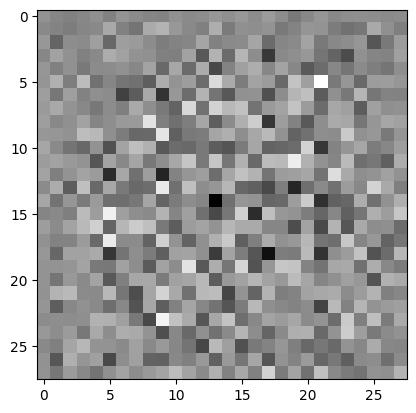

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Let's see the summary of generator model by using `.summary()` method

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

The generator model has a total of 2,330,944 parameters. Of those, 2,305,472 are trainable (these are the weights and biases of the model that will be updated during training), and 25,472 are non-trainable (these are the statistics used by the `BatchNormalization` layers, which are fixed during training). We can alos use visualize of the generator model better using the `plot_model` function from `tensorflow.keras.utils`. 

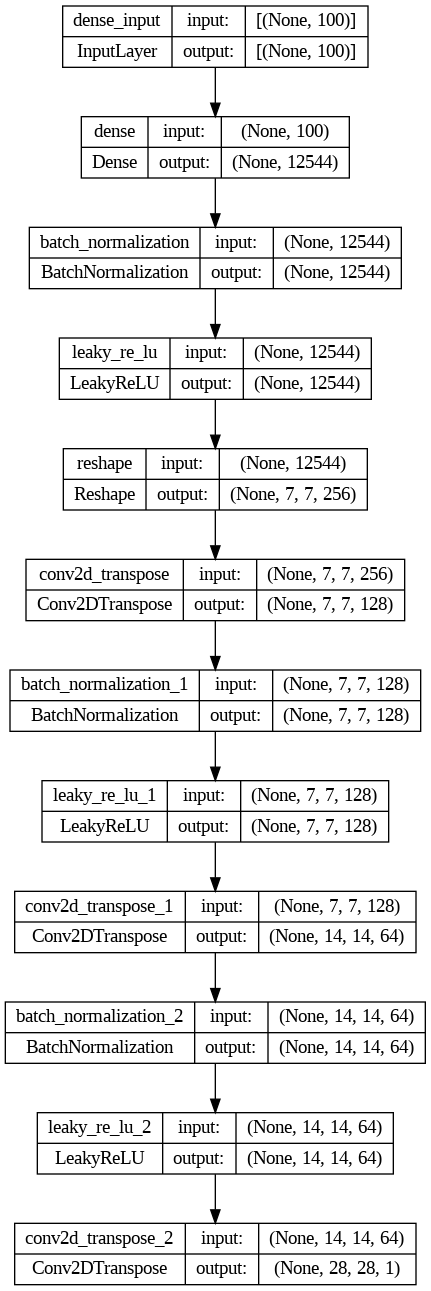

In [9]:
plot_model(generator, show_shapes=True)

This plot shows the flow of data through the generator model, from the input noise tensor to the final output image tensor. 

## 2.3. Creating Discriminator Model:

Now let's create discriminator model using Tensorflow. The discriminator model is defined using `tf.keras.Sequential()`. The model starts with a `Conv2D` layer that has 64 filters, each with a size of `5x5`, and a stride of 2 in both dimensions. This is followed by a `LeakyReLU` activation function that introduces non-linearity in the network, and a `Dropout` layer that randomly drops some of the activations to reduce overfitting. The same pattern is repeated with another `Conv2D` layer, but this time with 128 filters. The output of the second `onv2D` layer is then `flattened` into a 1D vector using a Flatten layer, and finally, a single `Dense` layer with a single output neuron is added to the network.

Note that the output of the discriminator is not normalized or passed through any activation function, since we will be using the sigmoid cross entropy loss function, which applies the sigmoid activation internally.

In [10]:
def make_discriminator_model():
    """
    Returns a discriminator model using Convolutional Neural Network (CNN) architecture.

    Input:
    This function does not take any input.

    Returns:
    model : A tf.keras.Sequential model representing the discriminator

    Input shape of model: (batch_size, 28, 28, 1)
    Output shape of model: (batch_size, 1)
    """
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

If the output of discriminator model is positive, it means the image is real. Let's write a function for that. 

In [11]:
def get_decision(decision):
  """
  This function takes in a decision tensor generated by the discriminator and 
  prints whether the image is real or generated by the AI. If the decision value
  is less than 0, the image is considered to be generated by the AI, and
  if it is greater than or equal to 0, the image is considered to be real.

  Input:
  decision: Tensor of shape (1, 1) containing the decision value for an image generated by the discriminator

  Returns:
  None
  """

  val = decision.numpy()[0, 0]
  if val < 0:
    print("AI generated image")
  else:
    print("real image")


It converts the output tensor to a numpy array and extracts the value at position (0,0) which represents the decision value. If the decision value is less than or equal to 0, the function prints "AI generated image" indicating that the input image is generated. Otherwise, it prints "real image" indicating that the input image is a real image.

Let's see how disciminator perform for AI generated image. This will print either "AI generated image" or "real image" depending on the decision made by the discriminator on the generated image. However, since the generated image is not yet trained, the decision is likely to be random and not representative of a trained discriminator's decision.

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
get_decision(decision)

AI generated image


## 2.4. Training functions:

Binary cross-entropy loss is a common loss function used for binary classification problems. In this case, the discriminator outputs a **single scalar** value that represents the probability of the input image being real or fake. The `tf.keras.losses.BinaryCrossentropy` function is used to compute the binary cross-entropy loss between the discriminator's predictions and the true labels. We are using `from_logits=True` which means that the inputs to the function are logits (i.e., unnormalized scores) rather than probabilities. `tf.keras.losses.BinaryCrossentropy` method returns a helper function to compute cross entropy loss for both generator and discriminator.

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Now time for creating loss functions. 

The `discriminator_loss` function calculates the binary cross-entropy loss between the output of the discriminator for real and fake images. The first argument, `real_output`, is the output of the discriminator when passed real images, while `fake_output` is the output of the discriminator when passed fake/generated images. The function first computes the loss for the real images (with the target label being 1) and then for the fake images (with the target label being 0). The two losses are added up to obtain the `total_loss`.

The `generator_loss` function calculates the binary cross-entropy loss between the output of the discriminator for the fake/generated images and a tensor of ones. **The idea is to train the generator to create images that are so realistic that the discriminator can't tell them apart from the real images.** Hence, the target label is set to 1.

Both loss functions use`tf.keras.losses.BinaryCrossentropy` with `from_logits=True`. When `from_logits=True`, the function expects the input to be unnormalized logits, rather than normalized probabilities.

In [14]:
def discriminator_loss(real_output, fake_output):
    """
    Computes the discriminator loss.

    Args:
    - real_output: A tensor representing the output of the discriminator on real images.
    - fake_output: A tensor representing the output of the discriminator on fake images.

    Returns:
    - total_loss: A scalar tensor representing the total discriminator loss.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Computes the generator loss.

    Args:
    - fake_output: A tensor representing the output of the discriminator on fake images.

    Returns:
    - A scalar tensor representing the generator loss.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Now let's define optimizer for both generator and discriminator. As Adam is an optimization algorithm that is commonly used for training neural networks, let's start with Adam optimizers with a learning rate of 1e-4. 

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

The `EPOCHS` variable sets the number of times the training loop will iterate over the entire dataset. Let's start with 5 epochs. 

The `num_examples_to_generate` variable sets the number of images that will be generated by the generator network during training. The `seed` variable is the input noise that will be fed to the generator network to produce the generated images. It is a tensor of shape `[num_examples_to_generate, noise_dim]` where `num_examples_to_generate` is the number of images to generate and `noise_dim` is the size of the input noise.

In [16]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Now let's define a TensorFlow checkpoint to save the state of the generator, discriminator, and their respective optimizers during training. This will allow us to resume training from a saved checkpoint in case the training process is interrupted for some reason. The checkpoint will be saved in the `checkpoint_dir` directory with a prefix of `"ckpt"`. The checkpoint object is created using the `tf.train.Checkpoint` class, and it takes as arguments the optimizers and models that we want to save.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Now let's create a function for each training step. 

First let's add `@tf.function` decorator to compile the function and optimize its execution using TensorFlow's autograph feature.

This `train_step` function takes in `images` as input, which represents the real images used for training. It starts by generating noise using a random normal distribution with `BATCH_SIZE` and `noise_dim` dimensions. Then, it uses this noise to generate fake images using the generator model.

Two `GradientTapes` are used to calculate the gradients of the `generator` and `discriminator` models. Within each `GradientTape` context, the model is called with the training flag set to True, which ensures that the correct behavior is followed for operations like dropout.

After generating fake and real images and calculating the losses using `generator_loss` and `discriminator_loss`, the gradients of the generator and discriminator models are computed using their respective `GradientTape` contexts. The gradients are then applied to the trainable variables of the `generator` and `discriminator` models using the `Adam` optimizer.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    """
    Performs a single training step on the GAN model.

    Args:
        images: A batch of real images.

    Returns:
        None - Applying gradient to the trainable variables of the 
        generator and discriminator models using the Adam optimizer
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Before defining the main training function, let's define a function to predict, save and show generated images. 

The function generates images using the generator model by calling it with the `test_input` noise and setting training to False. It then creates a `4x4` subplot grid of the generated images using `plt.subplot`, `plt.imshow`, and `plt.axis`. The generated images are rescaled to be between 0 and 255 using the formula `predictions[i, :, :, 0] * 127.5 + 127.5` and plotted using `plt.imshow`. Finally, the function saves the plot as a PNG file named `image_at_epoch_{epoch_number}.png` and displays the plot using `plt.show()`.

In [19]:
def generate_images(model, epoch, test_input):
    """
    Generate and save images using the generator model.

    Args:
        - model: generator model
        - epoch (int): current epoch number
        - test_input: input noise for the generator model

    Returns: 
        None

    Notice `training` is set to False.
    This is so all layers run in inference mode (batchnorm).
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

And finally `prediction` function takes in a dataset and epochs as input arguments. The function then loops over the epochs and for each epoch, loops over the dataset and calls the `train_step` function to train the model on each batch of images.

At the end of each epoch, the function calls the `generate_images` function to generate images produced by the generator model. The `display.clear_output(wait=True)` function call clears the output to display the newly generated images.

If the epoch number is divisible by 15, the function saves the model's checkpoint to the specified file path. Finally, the function prints the time taken for each epoch.

After all the epochs have completed, the function generates and saves images produced by the generator model for the final epoch.

In [20]:
def prediction(dataset, epochs):
  """
  Description:

  This function takes a dataset of images and an integer epochs as inputs. 
  It trains the generator and discriminator models for the specified number of 
  epochs using the train_step function. It generates images using the 
  generate_images function for every epoch.

  Args:
      - dataset: A TensorFlow dataset of images.
      - epochs: An integer specifying the number of epochs to train the models.

  Returns: 
      None
  """
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

Now, let's define final training function. This function, for each epoch, it loops through the dataset of real images and calls the `train_step` function to train the generator and discriminator models. After each epoch, it generates and saves some sample images using the `generate_images` function, and prints the time taken for that epoch. If the epoch number is divisible by 15, it saves the model using the checkpoint.save function. Finally, after all epochs are completed, it generates some sample images again using the `generate_images` function.

In [21]:
def train(dataset, epochs):
  """
  Trains the Generative Adversarial Network (GAN) model for the specified number of epochs.

  Args:
      - dataset: The input dataset used for training.
      - epochs (int): The number of epochs to train the model.

  Returns:
      None
  """
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

## 2.5. Training and testing model:

Now we can call `train` function and pass `train_dataset` and `EPOCHS` to train model. This will train exisiting `generator` and `discriminator` we initiated earlier. 

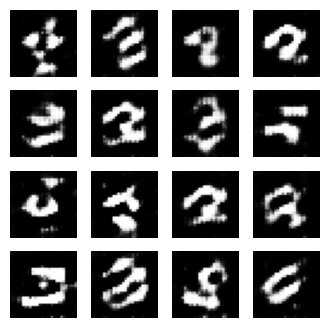

In [22]:
train(train_dataset, EPOCHS)

Now let's see how our GAN model is performing. Let's first generate a image

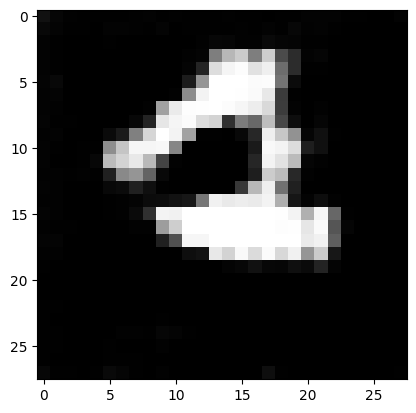

In [23]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

Let's see if discriminator can catch this. 

In [24]:
decision_2 = discriminator(generated_image_2)
get_decision(decision_2)

real image


Now we can test discriminator with real image. For similicity, we can predict for first 10 images:

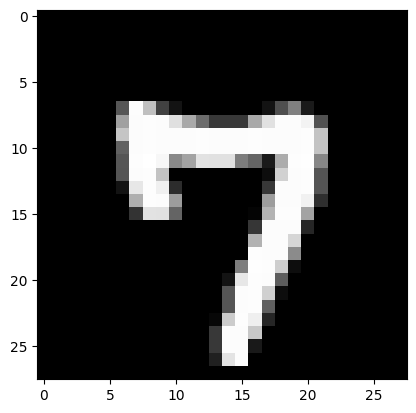

AI generated image


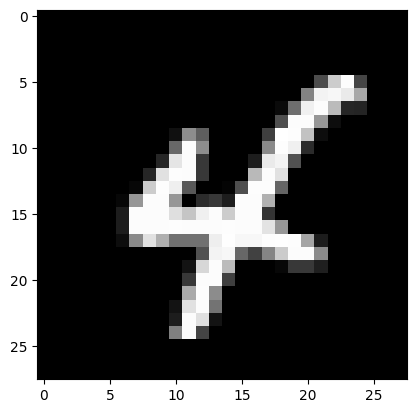

real image


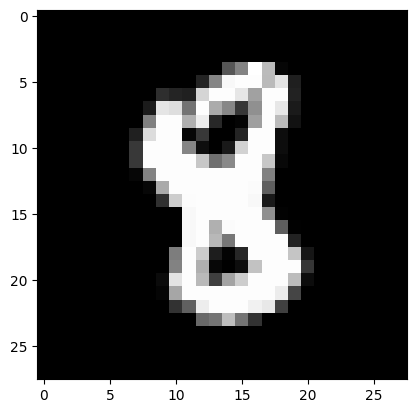

AI generated image


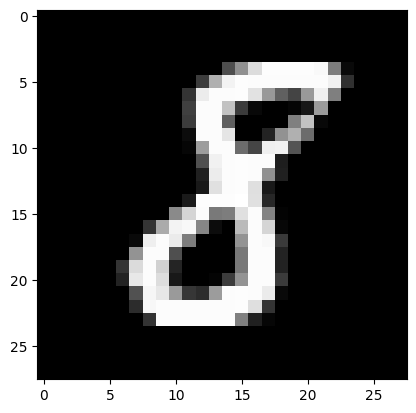

real image


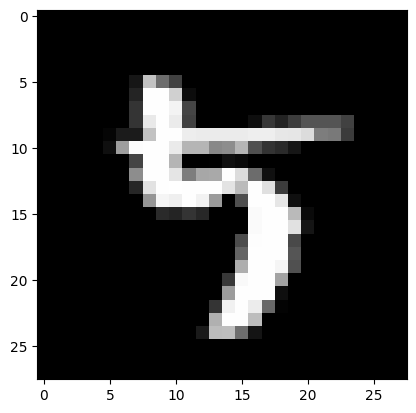

AI generated image


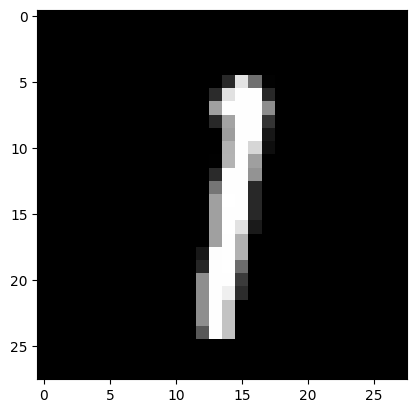

real image


In [25]:
count = 0
for image in test_dataset:
  # show images
  plt.imshow(image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.show()

  # predict
  decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
  get_decision(decision)

  count += 1
  if count > 5:
    break

Let's do the same thing with generated images. 

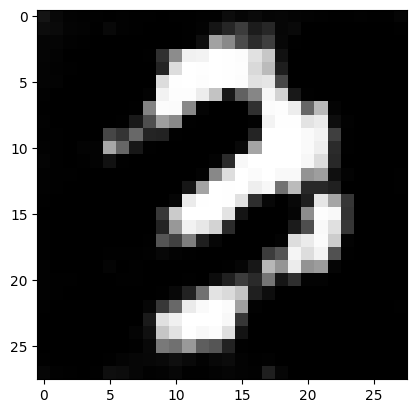

real image


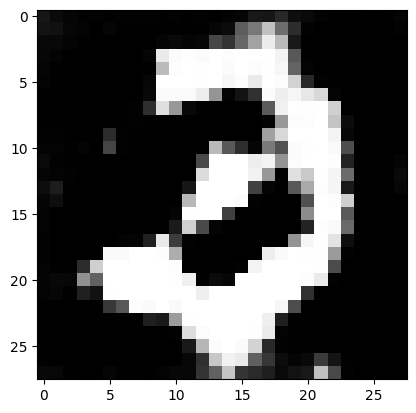

AI generated image


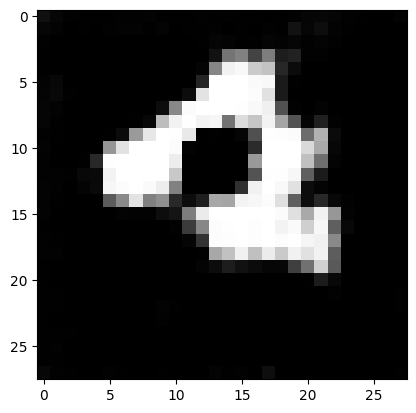

real image


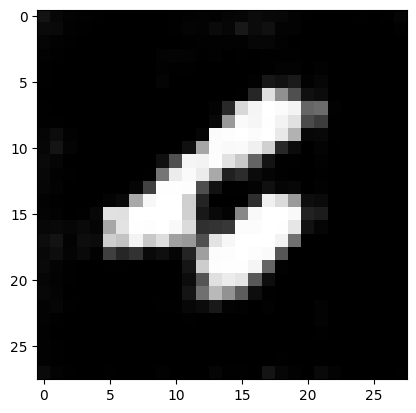

real image


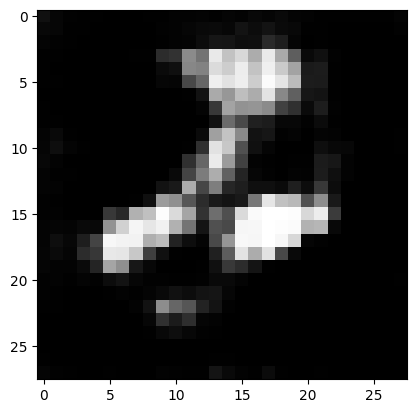

AI generated image


In [26]:
for i in range(0, 5):
  # show images
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.show()
  # predict
  decision = discriminator(generated_image)
  get_decision(decision)



Conclusion:

Now, let's assign these thing to a number. We can count number of correct and incorrect generated for real image loop and same thing for generator loop. For similicity, let's skip showing images.

In [27]:
result = {'correct' : 0, 
          'incorrect' : 0}

for image in test_dataset:
  # predict
  decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
  get_decision(decision)
  if decision.numpy()[0, 0] > 0:
    result['correct'] += 1
  else:
    result['incorrect'] += 1

AI generated image
real image
AI generated image
AI generated image
real image
AI generated image
real image
real image
AI generated image
AI generated image
AI generated image
real image
real image
AI generated image
real image
real image
AI generated image
real image
AI generated image
AI generated image
real image
real image
AI generated image
real image
AI generated image
AI generated image
real image
real image
real image
AI generated image
AI generated image
real image
real image
real image
real image
real image
real image
real image
AI generated image
real image


Let's find percentag of correct and incorrect:


In [28]:
percentage_correct_real = round(100*result['correct']/len(test_dataset))

print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))

Discriminator can detect 58% of real image correctly as real image!


Now let's test it over generated images. To be fair, let's tested it for same number test data we had. 

In [29]:
result_generator = {'correct' : 0, 
                    'incorrect' : 0}
for i in range(0, len(test_dataset)):
  # show images
  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  # predict
  decision = discriminator(generated_image)
  get_decision(decision)
  if decision.numpy()[0, 0] < 0:
    result_generator['correct'] += 1
  else:
    result_generator['incorrect'] += 1

real image
real image
real image
real image
real image
real image
AI generated image
AI generated image
real image
real image
AI generated image
real image
AI generated image
real image
AI generated image
real image
AI generated image
real image
real image
real image
AI generated image
AI generated image
AI generated image
AI generated image
AI generated image
AI generated image
real image
real image
AI generated image
AI generated image
AI generated image
real image
AI generated image
real image
real image
real image
AI generated image
real image
AI generated image
AI generated image


In [30]:
percentage_correct_fake = round(100*result_generator['correct']/len(test_dataset))
percentage_generator_tricked = round(100*result_generator['incorrect']/len(test_dataset))

print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 48% of generated image correctly as fake image!
Generator can trick discirmator in 52% of generated iamges!


So this shows that Discriminator is too good so that's might be a main reason we are not having good generator. Let's do some experiment in next section to make this better. 

## 2.6. Experiment:


To get results in this section, let's put togheter all code to make a function to get accuracy results.

In [31]:
def get_accuracy():

    result = {'correct' : 0, 
          'incorrect' : 0}

    for image in test_dataset:
      # predict
      decision = discriminator(tf.expand_dims(image[0 , :, :, :], axis=0))
      if decision.numpy()[0, 0] > 0:
        result['correct'] += 1
      else:
        result['incorrect'] += 1

    percentage_correct_real = round(100*result['correct']/len(test_dataset))


    result_generator = {'correct' : 0, 
                    'incorrect' : 0}
    for i in range(0, len(test_dataset)):
      # show images
      noise = tf.random.normal([1, 100])
      generated_image = generator(noise, training=False)

      # predict
      decision = discriminator(generated_image)
      if decision.numpy()[0, 0] < 0:
        result_generator['correct'] += 1
      else:
        result_generator['incorrect'] += 1

    percentage_correct_fake = round(100*result_generator['correct']/len(test_dataset))
    percentage_generator_tricked = round(100*result_generator['incorrect']/len(test_dataset))

    return percentage_correct_real, percentage_correct_fake, percentage_generator_tricked


Let's train models for 50 epochs now! 

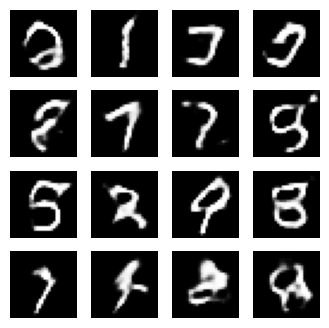

In [32]:
train(train_dataset, 50)


In [33]:
percentage_correct_real, percentage_correct_fake, percentage_generator_tricked = get_accuracy()
print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))
print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 68% of real image correctly as real image!
Discriminator can detect 72% of generated image correctly as fake image!
Generator can trick discirmator in 28% of generated iamges!


Let's check sample results.

real image


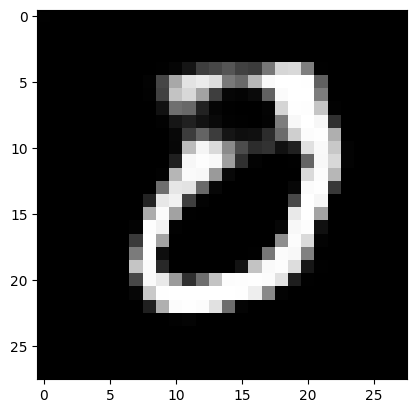

In [34]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

decision_2 = discriminator(generated_image_2)
get_decision(decision_2)

Let's train models for 400 epochs now!

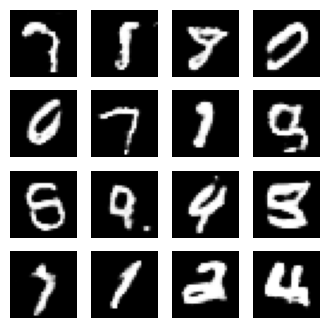

In [35]:
train(train_dataset, 400)

In [36]:
percentage_correct_real, percentage_correct_fake, percentage_generator_tricked = get_accuracy()
print('Discriminator can detect {}% of real image correctly as real image!'.format(percentage_correct_real))
print('Discriminator can detect {}% of generated image correctly as fake image!'.format(percentage_correct_fake))
print('Generator can trick discirmator in {}% of generated iamges!'.format(percentage_generator_tricked))

Discriminator can detect 50% of real image correctly as real image!
Discriminator can detect 95% of generated image correctly as fake image!
Generator can trick discirmator in 5% of generated iamges!


Now let's see sample of generator

AI generated image


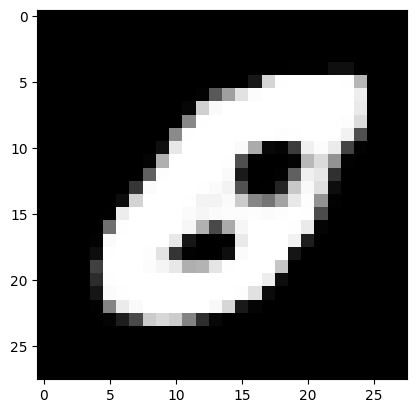

In [37]:
noise = tf.random.normal([1, 100])
generated_image_2 = generator(noise, training=False)

plt.imshow(generated_image_2[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

decision_2 = discriminator(generated_image_2)
get_decision(decision_2)

Based on these experiments, it sounds like training the GAN model for 400 epochs yielded the best results. It's important to note that the optimal number of epochs may vary depending on the specific dataset and model architecture being used. However, it's always a good idea to experiment with different hyperparameters and monitor the results to determine the best approach.

Overall, GANs are a powerful tool for generating realistic images, and there are many applications for this technology in fields such as art, fashion, and even medicine. Keep exploring and experimenting with GANs to see what kind of creative and innovative results you can achieve!

## References

[1] [https://www.tensorflow.org/tutorials/generative/dcgan](https://www.tensorflow.org/tutorials/generative/dcgan)

[2] [https://www.geeksforgeeks.org/generative-adversarial-network-gan/](https://www.geeksforgeeks.org/generative-adversarial-network-gan/)

[3] A. Creswell, T. White, V. Dumoulin, K. Arulkumaran, B. Sengupta and A. A. Bharath, "Generative Adversarial Networks: An Overview," in IEEE Signal Processing Magazine, vol. 35, no. 1, pp. 53-65, Jan. 2018, doi: 10.1109/MSP.2017.2765202.

[4] [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)

[5] [https://towardsdatascience.com/generative-adversarial-networks-gans-a-beginners-guide-f37c9f3b7817](https://towardsdatascience.com/generative-adversarial-networks-gans-a-beginners-guide-f37c9f3b7817)
